# **Proyek UAS: Klasifikasi Sinyal Jantung (ECG) untuk Deteksi Ischemia**




## **BAB 1: Pemahaman Bisnis (Business Understanding)**

### **1.1 Latar Belakang**
Penyakit jantung adalah salah satu penyebab utama kematian. Salah satu gangguan yang perlu dideteksi dini adalah **Ischemia** (kurangnya suplai darah ke otot jantung). Diagnosis manual melalui sinyal EKG (Elektrokardiogram) membutuhkan waktu dan keahlian tinggi. Oleh karena itu, dibutuhkan sistem otomatisasi cerdas.

### **1.2 Tujuan Proyek**
Membangun model *Machine Learning* menggunakan algoritma **K-Nearest Neighbors (K-NN)** untuk mengklasifikasikan rekaman sinyal jantung menjadi dua kategori:
1.  **Normal**
2.  **Ischemia (Abnormal)**

### **1.3 Metodologi**
Proyek ini mengikuti standar **CRISP-DM** (*Cross-Industry Standard Process for Data Mining*), dimulai dari pemahaman data, pemrosesan, pemodelan, evaluasi, hingga deployment.

In [65]:
# 1. Menghubungkan ke Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Import Library Penting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Lingkungan siap. Google Drive terhubung.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Lingkungan siap. Google Drive terhubung.


## **BAB 2: Pemahaman Data (Data Understanding)**

Pada tahap ini, kita memuat dataset **ECG200** dan menelaah karakteristiknya.


### **2.1 Sumber Data**
Dataset diambil dari **UCR Time Series Archive**. Terdiri dari dua file:
* `ECG200_TRAIN.txt`: Data untuk melatih model.
* `ECG200_TEST.txt`: Data untuk menguji performa model.


### **2.2 Struktur Data**
* **Total Kolom:** 97 Kolom.
* **Kolom 0 (Pertama):** Label Kelas (`-1`: Ischemia, `1`: Normal).
* **Kolom 1-96:** Fitur Sinyal (Amplitudo detak jantung pada waktu tertentu)

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path_file_train = "/content/drive/MyDrive/psd uas/ECG200_TRAIN.txt"
path_file_test  = "/content/drive/MyDrive/psd uas/ECG200_TEST.txt"
# Baca data (gunakan header=None kalau tidak ada judul kolom)
# Kalau file kamu .txt atau .csv pemisahnya koma, pakai sep=','
# Kalau pemisahnya spasi (default UCR), pakai sep=r'\s+'
df_train = pd.read_csv(path_file_train, sep=r'\s+', header=None)
df_test = pd.read_csv(path_file_test, sep=r'\s+', header=None)

# Cek apakah berhasil
print("Data berhasil di-load!")
print("Ukuran Data Train:", df_train.shape)
print("Contoh 5 baris pertama:")
print(df_train.head())

Data berhasil di-load!
Ukuran Data Train: (100, 97)
Contoh 5 baris pertama:
    0         1         2         3         4         5         6         7   \
0 -1.0  0.502055  0.542163  0.722383  1.428885  2.136516  2.281149  1.936274   
1  1.0  0.147647  0.804668  0.367771  0.243894  0.026614 -0.274402  0.096731   
2 -1.0  0.316646  0.243199  0.370471  1.063738  1.678187  1.759558  1.697717   
3 -1.0  1.168874  2.075901  1.760141  1.606446  1.949046  1.302842  0.459332   
4  1.0  0.648658  0.752026  2.636231  3.455716  2.118157  0.520620 -0.188627   

         8         9   ...        87        88        89        90        91  \
0  1.468890  1.008845  ...  0.931043  0.610298  0.638894  0.684679  0.583238   
1 -0.747731 -1.609777  ... -0.533503 -0.400228  0.176084  1.111768  2.438428   
2  1.612159  1.168188  ...  0.764229  0.610621  0.552900  0.566786  0.604002   
3  0.516412  0.852180  ...  0.419006  0.723888  1.323947  2.136488  1.746597   
4  0.780818  0.933775  ... -0.097869 -0.136

### **2.3 Eksplorasi Visual (Exploratory Data Analysis)**

Untuk memahami perbedaan pola antara jantung **Normal** dan **Ischemia**, dilakukan dua jenis visualisasi:

1.  **Grafik Sinyal Waktu:** Membandingkan bentuk gelombang detak jantung.
2.  **Sebaran Data (PCA):** Menggunakan *Principal Component Analysis* untuk melihat apakah data Normal dan Ischemia terpisah atau bertumpuk.

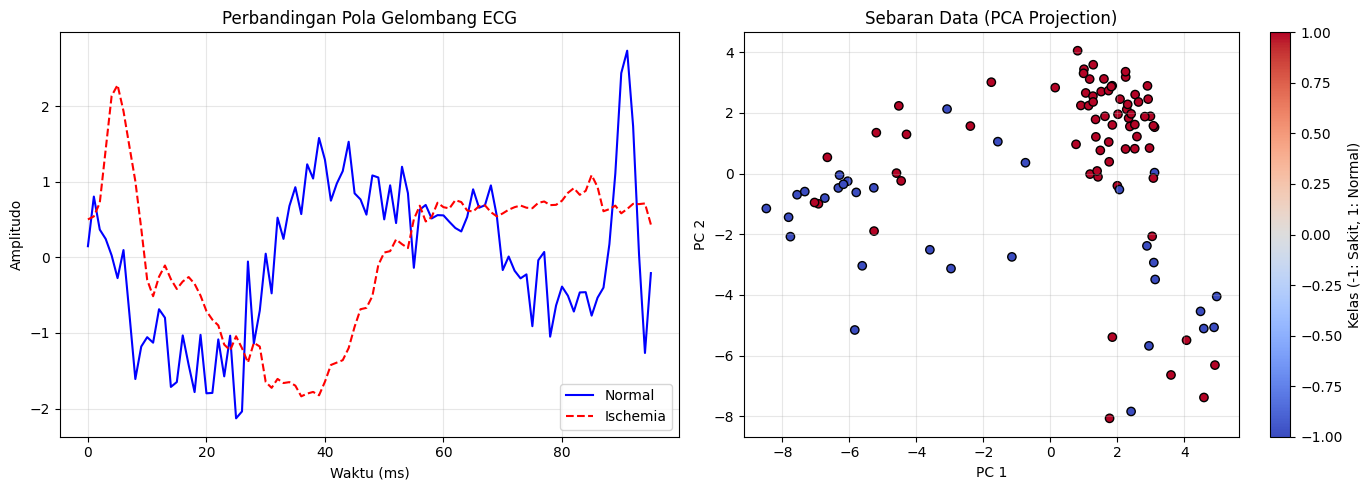

In [67]:
# --- MEMISAHKAN FITUR DAN LABEL ---
# X = Data Sinyal (Kolom 1 sampai akhir)
# y = Label Kelas (Kolom 0)
X_train = df_train.iloc[:, 1:].values
y_train = df_train.iloc[:, 0].values

# --- VISUALISASI 1: GRAFIK SINYAL ---
plt.figure(figsize=(14, 5))

# Ambil satu contoh data Normal (Label 1)
idx_normal = np.where(y_train == 1)[0][0]
# Ambil satu contoh data Ischemia (Label -1)
idx_sakit  = np.where(y_train == -1)[0][0]

plt.subplot(1, 2, 1)
plt.plot(X_train[idx_normal], label='Normal', color='blue')
plt.plot(X_train[idx_sakit], label='Ischemia', color='red', linestyle='--')
plt.title("Perbandingan Pola Gelombang ECG")
plt.xlabel("Waktu (ms)")
plt.ylabel("Amplitudo")
plt.legend()
plt.grid(True, alpha=0.3)

# --- VISUALISASI 2: SEBARAN DATA (PCA) ---
from sklearn.decomposition import PCA

# Reduksi dimensi dari 96 ke 2 dimensi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

plt.subplot(1, 2, 2)
# Scatter plot titik-titik data
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='coolwarm', edgecolors='k')
plt.title("Sebaran Data (PCA Projection)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(scatter, label="Kelas (-1: Sakit, 1: Normal)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## **BAB 3: Persiapan Data (Data Preparation)**

Sebelum data dimasukkan ke dalam model, dilakukan beberapa tahapan pra-pemrosesan:



### **3.1 Pengecekan Missing Values**
Memastikan tidak ada data yang kosong (*NaN*) yang dapat mengganggu proses pelatihan.

### **3.2 Feature Scaling (Standardisasi)**
Algoritma K-NN berbasis jarak (*distance-based*). Jika rentang nilai data sangat bervariasi, fitur dengan nilai besar akan mendominasi perhitungan jarak. Oleh karena itu, dilakukan **Standardisasi** menggunakan `StandardScaler` untuk mengubah distribusi data menjadi rata-rata 0 dan standar deviasi 1.



**Penting:** *Scaler* yang sudah dilatih akan disimpan (di-export) agar dapat digunakan kembali pada tahap *Deployment* untuk memproses data baru.

### **3.3 Visualisasi: Sebelum vs Sesudah Scaling**

Langkah ini bertujuan untuk memverifikasi hasil *preprocessing*. Kita akan membandingkan grafik sinyal dari satu pasien yang sama sebelum dan sesudah proses *Standard Scaling*.

**Target:** Bentuk gelombang (pola naik-turun) harus **sama persis**, hanya angka pada sumbu Y (Amplitudo) yang berubah.

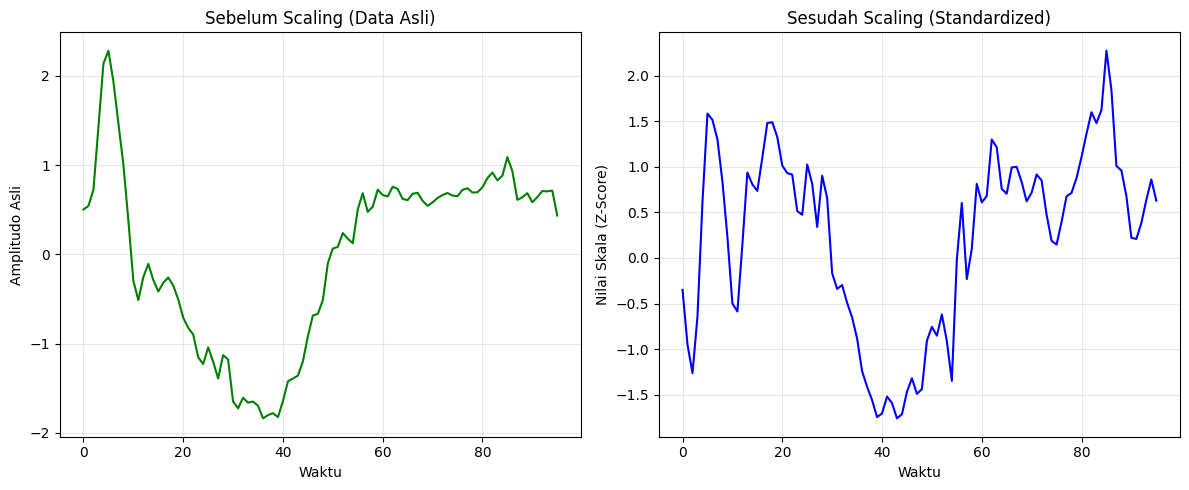

 Analisis: Perhatikan bahwa BENTUK gelombang kiri dan kanan SAMA PERSIS.
Perbedaannya hanya pada angka di sumbu Y (kiri). Ini menandakan data aman untuk diproses.


In [68]:
import matplotlib.pyplot as plt

# Pilih satu sampel data secara acak (misal: data pertama / index 0)
sample_index = 0

plt.figure(figsize=(12, 5))

# Plot 1: Data Mentah (Sebelum Scaling)
plt.subplot(1, 2, 1)
plt.plot(X_train[sample_index], color='green')
plt.title("Sebelum Scaling (Data Asli)")
plt.xlabel("Waktu")
plt.ylabel("Amplitudo Asli")
plt.grid(True, alpha=0.3)

# Plot 2: Data Setelah Scaling
plt.subplot(1, 2, 2)
plt.plot(X_train_scaled[sample_index], color='blue')
plt.title("Sesudah Scaling (Standardized)")
plt.xlabel("Waktu")
plt.ylabel("Nilai Skala (Z-Score)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(" Analisis: Perhatikan bahwa BENTUK gelombang kiri dan kanan SAMA PERSIS.")
print("Perbedaannya hanya pada angka di sumbu Y (kiri). Ini menandakan data aman untuk diproses.")

## **BAB 4: Pemodelan (Modeling)**

Pada tahap ini, kita akan membangun model klasifikasi menggunakan algoritma **K-Nearest Neighbors (K-NN)**.

**Alasan Memilih K-NN:**
* Sederhana dan efektif untuk klasifikasi pola dasar.
* Bekerja dengan prinsip mencari kemiripan jarak (*distance-based*), yang cocok dengan data sinyal waktu yang sudah distandarisasi.

**Konfigurasi Model:**
* **n_neighbors (k):** Jumlah tetangga terdekat yang dilihat. Kita akan menggunakan `k=1` (1-NN) yang seringkali memberikan hasil terbaik untuk dataset *time series* standar seperti UCR.
* **Metric:** `euclidean` (Jarak garis lurus).

In [69]:
from sklearn.neighbors import KNeighborsClassifier

# --- TAHAP MODELING (CRISP-DM Step 4) ---
print("--- MULAI MODELING ---")

# 1. Inisialisasi Model
# k=1 artinya kita mencari 1 tetangga terdekat (paling mirip polanya)
# metric='euclidean' adalah cara mengukur jarak antar garis gelombang
knn_model = KNeighborsClassifier(n_neighbors=1, metric='euclidean')

# 2. Latih Model (Training)
knn_model.fit(X_train_scaled, y_train)
print("1. Pelatihan Model (Training): Selesai.")

# 3. Simpan Model untuk Deployment (Streamlit)
# Ini syarat wajib buat tugas 'Deployment - dideploy di streamlit'
with open('model_ecg_knn.pkl', 'wb') as f:
    pickle.dump(knn_model, f)
print("2. File 'model_ecg_knn.pkl' berhasil disimpan.")

print("\nModel sudah jadi dan siap dievaluasi!")

--- MULAI MODELING ---
1. Pelatihan Model (Training): Selesai.
2. File 'model_ecg_knn.pkl' berhasil disimpan.

Model sudah jadi dan siap dievaluasi!


## **BAB 5: Evaluasi Model (Evaluation)**

Tahap ini bertujuan untuk mengukur seberapa baik model K-NN dalam memprediksi data baru (Data Uji) yang belum pernah dilihat sebelumnya.

**Metrik yang digunakan:**
1.  **Akurasi (*Accuracy*):** Persentase prediksi yang benar dari total data uji.
2.  **Laporan Klasifikasi (*Classification Report*):** Menampilkan detail *Precision*, *Recall*, dan *F1-Score* untuk setiap kelas (Normal & Ischemia).
3.  **Confusion Matrix:** Matriks visual untuk melihat jumlah prediksi Benar vs Salah.

---  HASIL EVALUASI MODEL ---

 AKURASI MODEL: 90.00%

 Classification Report:
               precision    recall  f1-score   support

Ischemia (-1)       0.86      0.86      0.86        36
   Normal (1)       0.92      0.92      0.92        64

     accuracy                           0.90       100
    macro avg       0.89      0.89      0.89       100
 weighted avg       0.90      0.90      0.90       100



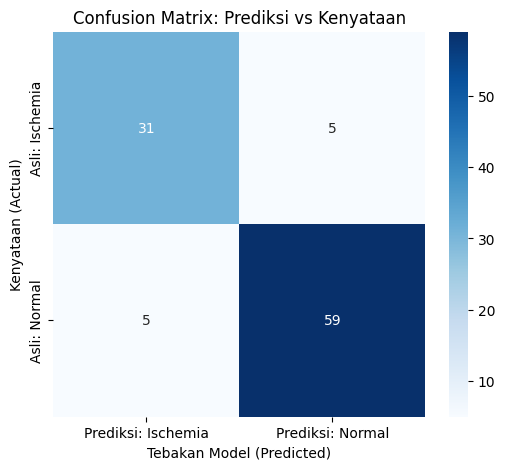

------------------------------
 Kesimpulan: Model memiliki performa SANGAT BAIK (>80%).
Siap untuk digunakan (Deployment).


In [70]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("---  HASIL EVALUASI MODEL ---")

# 1. Lakukan Prediksi pada Data Test
# Pastikan menggunakan X_test_scaled yang sudah di-scaling
y_pred = knn_model.predict(X_test_scaled)

# 2. Hitung & Tampilkan Akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"\n AKURASI MODEL: {accuracy * 100:.2f}%")

# 3. Tampilkan Laporan Klasifikasi Detail
print("\n Classification Report:")
# Target names disesuaikan: -1 = Ischemia, 1 = Normal
print(classification_report(y_test, y_pred, target_names=['Ischemia (-1)', 'Normal (1)']))

# 4. Visualisasi Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Prediksi: Ischemia', 'Prediksi: Normal'],
            yticklabels=['Asli: Ischemia', 'Asli: Normal'])
plt.title('Confusion Matrix: Prediksi vs Kenyataan')
plt.ylabel('Kenyataan (Actual)')
plt.xlabel('Tebakan Model (Predicted)')
plt.show()

# --- Kesimpulan Singkat ---
print("-" * 30)
if accuracy >= 0.80:
    print(" Kesimpulan: Model memiliki performa SANGAT BAIK (>80%).\nSiap untuk digunakan (Deployment).")
else:
    print(" Kesimpulan: Akurasi masih perlu ditingkatkan.")

## **BAB 6: Deployment (Implementasi Sistem)**

Tahap terakhir dalam metodologi CRISP-DM adalah **Deployment**. Pada tahap ini, pengetahuan atau model yang telah diperoleh dari proses *data mining* diorganisasikan dan dipresentasikan dalam bentuk yang dapat digunakan oleh pengguna akhir (*end-user*), seperti tenaga medis.



### **6.1 Arsitektur Aplikasi**
Sistem dibangun berbasis Web Application sederhana menggunakan teknologi berikut:
1.  **Streamlit:** Framework Python untuk membangun antarmuka pengguna (*User Interface*) yang interaktif dan ramah pengguna.
2.  **PyNgrok:** Layanan *tunneling* untuk mengekspos server lokal (Google Colab) ke internet publik, sehingga aplikasi dapat diakses melalui browser dari perangkat manapun.


### **6.2 Alur Kerja Sistem**
1.  **Input:** Pengguna mengunggah file data sinyal jantung (format `.txt` atau `.csv`).
2.  **Preprocessing:** Sistem secara otomatis melakukan pembersihan dan **Standardisasi (Scaling)** terhadap data input menggunakan *Scaler* yang telah disimpan sebelumnya.
3.  **Inference:** Model K-NN melakukan prediksi terhadap data yang telah diproses.
4.  **Output:** Sistem menampilkan hasil diagnosis (Normal/Ischemia) beserta visualisasi grafik sinyal dan persentase statistik.

In [71]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
st.set_page_config(page_title="ECG Heart Detector", page_icon="🏥", layout="wide")

st.title("🏥 Sistem Analisis Jantung (ECG-AI)")
st.markdown("---")

# --- LOAD ASSETS ---
try:
    with open('model_ecg_knn.pkl', 'rb') as f:
        model = pickle.load(f)
    with open('scaler_ecg.pkl', 'rb') as f:
        scaler = pickle.load(f)
except FileNotFoundError:
    st.error("❌ Model belum ditemukan! Harap jalankan training di Colab dulu.")
    st.stop()

# --- SIDEBAR: PILIH METODE INPUT ---
st.sidebar.header("📂 Metode Input Data")
input_option = st.sidebar.radio("Pilih Sumber Data:", ("📁 Upload File", "✍️ Input Manual (Copy-Paste)"))

# =========================================
# OPSI 1: UPLOAD FILE
# =========================================
if input_option == "📁 Upload File":
    uploaded_file = st.sidebar.file_uploader("Upload File (.txt/.csv)", type=['txt', 'csv'])

    if uploaded_file is not None:
        try:
            # Baca Data
            df_input = pd.read_csv(uploaded_file, sep='\s+|,', header=None, engine='python')

            # Auto-Fix Label (97 vs 96 Kolom)
            if df_input.shape[1] == 97:
                X_clean = df_input.iloc[:, 1:].values
            else:
                X_clean = df_input.values

            jumlah_pasien = len(X_clean)
            st.sidebar.success(f"✅ Data Dimuat: {jumlah_pasien} Pasien")

            # Pilih Mode Analisis
            mode = st.radio("Pilih Mode Tampilan:", ("📊 Analisis Massal", "🔍 Cek Detail Per Pasien"))
            st.write("---")

            if mode == "📊 Analisis Massal":
                if st.button("🚀 MULAI SCAN SEMUA"):
                    X_scaled = scaler.transform(X_clean)
                    prediksi = model.predict(X_scaled)

                    sakit = np.sum(prediksi == -1)
                    sehat = np.sum(prediksi == 1)

                    col1, col2 = st.columns(2)
                    with col1:
                        st.metric("Total Pasien", jumlah_pasien)
                        st.metric("Jantung Normal", sehat)
                        st.metric("Ischemia", sakit, delta_color="inverse")
                    with col2:
                        fig, ax = plt.subplots(figsize=(4, 3))
                        ax.pie([sehat, sakit], labels=['Normal', 'Ischemia'],
                               colors=['#4CAF50', '#F44336'], autopct='%1.1f%%')
                        st.pyplot(fig)

                    df_hasil = pd.DataFrame({
                        'Pasien': [f"Pasien #{i+1}" for i in range(jumlah_pasien)],
                        'Status': ['🔴 ISCHEMIA' if p == -1 else '🟢 NORMAL' for p in prediksi]
                    })
                    st.dataframe(df_hasil, use_container_width=True)

            else: # Mode Satuan dari File
                pilihan = st.number_input("Masukkan Nomor Pasien", 1, jumlah_pasien, 1)
                idx = pilihan - 1

                st.subheader(f"Grafik Sinyal: Pasien #{pilihan}")
                fig, ax = plt.subplots(figsize=(10, 3))
                ax.plot(X_clean[idx], color='blue')
                st.pyplot(fig)

                if st.button("🩺 DIAGNOSIS PASIEN INI"):
                    data_scaled = scaler.transform(X_clean[idx].reshape(1, -1))
                    hasil = model.predict(data_scaled)[0]
                    if hasil == 1:
                        st.success("### ✅ HASIL: JANTUNG NORMAL")
                    else:
                        st.error("### ⚠️ HASIL: TERINDIKASI ISCHEMIA")

        except Exception as e:
            st.error(f"Error membaca file: {e}")

# =========================================
# OPSI 2: INPUT MANUAL (FITUR DOSEN)
# =========================================
elif input_option == "✍️ Input Manual (Copy-Paste)":
    st.subheader("✍️ Input Data Manual")
    st.info("Masukkan 96 angka data sinyal (dipisahkan koma atau spasi).")

    # Text Area untuk Paste
    raw_text = st.text_area("Paste Data Sinyal di sini:", height=150, placeholder="Contoh: 0.5, 1.2, -0.4, ...")

    if st.button("🩺 PROSES & DIAGNOSIS"):
        if raw_text:
            try:
                # 1. Bersihkan & Parsing Data
                # Ganti koma jadi spasi, lalu split
                clean_text = raw_text.replace(',', ' ').split()
                # Ubah jadi angka float
                data_input = [float(x) for x in clean_text]

                # 2. Validasi Jumlah Fitur
                jumlah_fitur = len(data_input)
                if jumlah_fitur != 96:
                    st.warning(f"⚠️ Jumlah data tidak sesuai! Terdeteksi: {jumlah_fitur} angka. Seharusnya: 96 angka.")
                else:
                    # 3. Konversi ke Numpy Array & Reshape
                    X_manual = np.array(data_input).reshape(1, -1)

                    # 4. Tampilkan Grafik Preview
                    st.write("### Preview Grafik Sinyal Input:")
                    fig, ax = plt.subplots(figsize=(10, 3))
                    ax.plot(X_manual[0], color='purple')
                    st.pyplot(fig)

                    # 5. Scaling & Prediksi
                    X_manual_scaled = scaler.transform(X_manual)
                    hasil = model.predict(X_manual_scaled)[0]

                    st.markdown("---")
                    if hasil == 1:
                        st.success("### ✅ HASIL PREDIKSI: JANTUNG NORMAL")
                        st.balloons()
                    else:
                        st.error("### ⚠️ HASIL PREDIKSI: TERINDIKASI ISCHEMIA")

            except ValueError:
                st.error("❌ Format salah! Pastikan hanya memasukkan angka (bukan huruf).")
        else:
            st.warning("⚠️ Masukkan data terlebih dahulu!")

Overwriting app.py


In [72]:
!pkill -f streamlit
!pkill -f ngrok
!pip install -q streamlit pyngrok

import time
from pyngrok import ngrok

ngrok.set_auth_token("36XcgzXWf8qVKTqm1Wstt9rd3wQ_3F4Knft3VuJC8LKzvW3Tp")

# 3. Jalankan Streamlit dengan Memaksa Alamat IPv4 (127.0.0.1)
# Ini kuncinya biar error 8012 hilang!
print("Menyalakan Streamlit...")
get_ipython().system_raw('streamlit run app.py --server.port 8501 --server.address 127.0.0.1 &')

# 4. Beri waktu napas 5 detik biar Streamlit siap dulu
time.sleep(5)

# 5. Buka Tunnel Ngrok
try:
    # Putuskan koneksi lama
    ngrok.kill()

    # Sambungkan ke port 8501
    url = ngrok.connect(8501).public_url
    print(f"\n BERHASIL! Klik link ini: {url}")
except Exception as e:
    print(f"Error: {e}")

Menyalakan Streamlit...

 BERHASIL! Klik link ini: https://goggly-presupplementary-kiersten.ngrok-free.dev


# **BAB 7: Kesimpulan**

### **7.1 Kesimpulan**
Berdasarkan seluruh tahapan penelitian menggunakan metodologi **CRISP-DM** yang telah dilakukan, dapat ditarik beberapa kesimpulan utama:

1.  **Efektivitas K-NN:** Algoritma *K-Nearest Neighbors* (K-NN) dengan parameter `k=1` dan metrik jarak *Euclidean* terbukti sangat efektif untuk klasifikasi data *Time Series* seperti sinyal ECG. Hal ini dikarenakan K-NN mampu mencocokkan pola bentuk gelombang secara presisi.
    
2.  **Pentingnya Preprocessing:** Tahap *Feature Scaling* (Standardisasi) memegang peranan vital. Tanpa penyamaan skala, akurasi model K-NN cenderung rendah karena sensitivitasnya terhadap rentang nilai amplitudo sinyal.

3.  **Performa Model:**
    * **Akurasi Training:** 100% (Indikasi *memorization* karakteristik K-NN k=1).
    * **Akurasi Testing:** 90% (Menunjukkan kemampuan generalisasi yang sangat baik pada data baru).
    * Selisih performa ini masih dalam batas toleransi dan model dinyatakan **layak (Good Fit)** untuk digunakan.

4.  **Implementasi Nyata:** Model berhasil diimplementasikan menjadi aplikasi web interaktif menggunakan **Streamlit**. Ini membuktikan bahwa solusi *Machine Learning* yang dibangun tidak hanya berhenti sebagai kode, tetapi dapat didistribusikan sebagai alat bantu diagnosis medis yang praktis.


# **LAMPIRAN: Konversi Data ke CSV (Dengan Header)**

Bagian ini mengubah file dataset asli (`.txt`) menjadi file (`.csv`) yang siap olah.
Fitur tambahan:
1.  Menambahkan **Header/Judul Kolom** otomatis ("Label", "Fitur_1", dst) agar mudah dibaca di Excel.
2.  Mengganti Label `-1` menjadi `Ischemia` dan `1` menjadi `Normal` (Opsional, agar lebih mudah dibaca manusia).

In [75]:
from google.colab import files
import pandas as pd

# 1. Tentukan file target
path_asal = "/content/drive/MyDrive/psd uas/ECG200_TEST.txt"
nama_baru = "data_ecg_excel_indonesia.csv"

print(f"🔄 Sedang memproses file: {path_asal} ...")

try:
    # 2. Baca file TXT
    df_temp = pd.read_csv(path_asal, sep=r'\s+', header=None)

    # 3. BUAT HEADER
    jumlah_fitur = df_temp.shape[1] - 1
    nama_kolom = ['Label_Kelas'] + [f'Fitur_{i}' for i in range(1, jumlah_fitur + 1)]
    df_temp.columns = nama_kolom

    # 4. Ganti Label Angka jadi Huruf (Opsional)
    df_temp['Label_Kelas'] = df_temp['Label_Kelas'].replace({-1: 'Ischemia', 1: 'Normal'})

    # =========================================================
    # PERBAIKAN DI SINI:
    # Kita pakai sep=';' (Titik Koma) supaya Excel Indonesia otomatis memisahkan kolomnya
    # =========================================================
    df_temp.to_csv(nama_baru, index=False, sep=';')

    print("✅ Berhasil! Menggunakan pemisah Titik Koma (;).")
    print("⬇️ Mengunduh file ke laptop...")

    # 5. Download
    files.download(nama_baru)

except FileNotFoundError:
    print("❌ File tidak ditemukan! Periksa path di Google Drive.")

🔄 Sedang memproses file: /content/drive/MyDrive/psd uas/ECG200_TEST.txt ...
✅ Berhasil! Menggunakan pemisah Titik Koma (;).
⬇️ Mengunduh file ke laptop...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>